# Feature Selection

The number of columns in the processed data set was 53, which made the models less interpretable. So we implemented the following three techniques using `sklearn` for feature selection:
- Select From Model
- Recursive Feature Elimination with cross-validation (RFECV)
- Recursive Feature Elimination (RFE) 

In this notebook, we have explored all the three approaches. However, we have finally used the features selected using RFE method because:
- SelectFromModel() removed just one feature and returned 52 selected features
- RFECV() was inconsistent and the selected features varied depending upon the number of observations used
- RFE() was consistent and gave the same 8 features under multiple scenarios.

**Conclusions from this notebook:**

We observed that the same recall score could be achieved using only eight (8) features. This resulted in dimensionality reduction without impacting the model performance. The final selected features were used subsequently for model training and risk classification.

## Imports

In this section, we load all the packages required to run this notebook.

In [1]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFE, SelectFromModel, RFECV
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read in train dataset

In this section:
- We load the training data, and look at first 5 values and shape. This data has already been cleaned, processed and new features created.
- Separate the data into X-train (features) and y-train (output)
- Use Oversampling (SMOTE) technique to create a balanced training data-set

In [2]:
api_df = pd.read_excel("../../data/processed/preprocessed_train.xlsx")
api_df.head()

,is_pii,is_fii,NRI score,authentication_processed,usage_base_processed,AI & Data Science,Business & Technology,Environment & Weather,Finance & Banking,GeoInformatics & Navigation,...,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count,Risk_Label
0,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,Low
1,True,False,77.850013,1,2,0,0,0,0,0,...,0,0,0,1,0,0,0,6,1,Low
2,False,False,76.479613,1,2,0,1,0,0,0,...,0,0,0,1,0,0,0,3,1,Medium
3,True,False,76.479613,1,2,0,0,0,0,0,...,1,0,0,0,0,0,0,5,0,Low
4,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,3,Low


In [3]:
api_df.shape

(1316, 53)

In [4]:
# X, y split
X_train, y_train = api_df.drop(columns=["Risk_Label"]), api_df["Risk_Label"]

In [5]:
# Smote function
def create_smote(X, y, k_neighbors):
    oversample = SMOTE(k_neighbors = k_neighbors)
    X, y = oversample.fit_resample(X, y)
    return X, y

In [6]:
# Balanced training data
X_train, y_train = create_smote(X_train, y_train, 2)

## Helper Code

In this section, we provide helper code that is used in the subsequent sections for evaluating the models. The function `mean_std_cross_val_scores()` computes the train score and test score for the `scoring_metric` using sklearn's `cross_validate()`. The final scores are returned in `results` dictionary.

In [7]:
results = {}
scoring_metric = ["accuracy", "f1_macro", "recall_macro"]

In [8]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

## Baseline Performance

In this section, we evaluate the baseline score for `Logistic Regression` model and `Decision Tree` model on the evaluation metrics given in `scoring_metric`. The baseline model performance is obtained before hyper-parameter optimization and without any feature selection.

In [9]:
# Logistic Regression model
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
results["lr"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [10]:
# Decision Tree model
pipe_dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
results["dt"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [11]:
pd.DataFrame(results)

,lr,dt
fit_time,0.080 (+/- 0.016),0.020 (+/- 0.008)
score_time,0.016 (+/- 0.001),0.013 (+/- 0.003)
test_accuracy,0.995 (+/- 0.003),0.998 (+/- 0.002)
train_accuracy,0.999 (+/- 0.000),1.000 (+/- 0.000)
test_f1_macro,0.995 (+/- 0.003),0.998 (+/- 0.002)
train_f1_macro,0.999 (+/- 0.000),1.000 (+/- 0.000)
test_recall_macro,0.995 (+/- 0.003),0.998 (+/- 0.002)
train_recall_macro,0.999 (+/- 0.000),1.000 (+/- 0.000)


## Feature Importance

In this section, we evaluate the importance of all features used for training the models. We have used the `magnitude of coefficients` obtained from LogisticRegression model to get the relative importance of features. It is to be noted that the higher the magnitude of the coefficient, the higher will be it's influence on prediction. Hence, higher will be the importance of that feature. Similarly, a feature with low coefficient magnitude will have low importance.  

In [12]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [13]:
data_coef = {
    "coefficient": pipe_lr.named_steps['logisticregression'].coef_.tolist()[0],
    "magnitude": np.absolute(pipe_lr.named_steps['logisticregression'].coef_)[0],
}
coef_df = pd.DataFrame(data_coef, index=X_train.columns).sort_values("magnitude", ascending=False)
coef_df

,coefficient,magnitude
is_fii,2.249224,2.249224
is_pii,0.962659,0.962659
Information & Science,-0.945055,0.945055
server,-0.893115,0.893115
metadata_fields_count,-0.869871,0.869871
x0_Missing,-0.849255,0.849255
Social Media & Technology,-0.670150,0.670150
Government & Public Services,-0.666714,0.666714
Software & Services,-0.637901,0.637901
security_test_result_processed,0.562086,0.562086


## Feature Selection

In this section, we use sklearn to implement the following three feature selection techniques for dimensionality reduction:
- Select From Model (SelectFromModel())
- Recursive Feature Elimination with cross-validation (RFECV())
- Recursive Feature Elimination (RFE()) 

### Feature Selection using SelectFromModel

In this section, we implement feature selection using SelectFromModel(). It is observed that using this method, only one feature is removed and remaining 52 features are selected.

In [14]:
select_lr = SelectFromModel(LogisticRegression(), threshold="mean")

In [15]:
pipe_dt_model_based = make_pipeline(
    StandardScaler(), select_lr, DecisionTreeClassifier(random_state=42)
)
results["dt+model_based_fs"] = mean_std_cross_val_scores(
    pipe_dt_model_based, X_train, y_train,
    return_train_score=True, scoring=scoring_metric
)

In [16]:
pd.DataFrame(results)

,lr,dt,dt+model_based_fs
fit_time,0.080 (+/- 0.016),0.020 (+/- 0.008),0.087 (+/- 0.018)
score_time,0.016 (+/- 0.001),0.013 (+/- 0.003),0.015 (+/- 0.006)
test_accuracy,0.995 (+/- 0.003),0.998 (+/- 0.002),0.997 (+/- 0.003)
train_accuracy,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_f1_macro,0.995 (+/- 0.003),0.998 (+/- 0.002),0.997 (+/- 0.003)
train_f1_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_recall_macro,0.995 (+/- 0.003),0.998 (+/- 0.002),0.997 (+/- 0.003)
train_recall_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


In [17]:
pipe_dt_model_based.fit(X_train, y_train)
pipe_dt_model_based.named_steps["selectfrommodel"].n_features_in_

52

### Feature Selection using RFECV

In this section, we implement feature selection using RFECV(). It is observed that this method is inconsistent and the selected features varied depending upon the number of observations used.

In [18]:
rfecv = RFECV(LogisticRegression())
pipe_dt_rfecv = make_pipeline(
    StandardScaler(), rfecv, DecisionTreeClassifier(random_state=42)
)
results["dt+rfecv"] = mean_std_cross_val_scores(
    pipe_dt_rfecv, X_train, y_train, 
    return_train_score=True, scoring=scoring_metric
)

In [19]:
pd.DataFrame(results)

,lr,dt,dt+model_based_fs,dt+rfecv
fit_time,0.080 (+/- 0.016),0.020 (+/- 0.008),0.087 (+/- 0.018),13.987 (+/- 0.828)
score_time,0.016 (+/- 0.001),0.013 (+/- 0.003),0.015 (+/- 0.006),0.015 (+/- 0.004)
test_accuracy,0.995 (+/- 0.003),0.998 (+/- 0.002),0.997 (+/- 0.003),0.999 (+/- 0.001)
train_accuracy,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_f1_macro,0.995 (+/- 0.003),0.998 (+/- 0.002),0.997 (+/- 0.003),0.999 (+/- 0.001)
train_f1_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_recall_macro,0.995 (+/- 0.003),0.998 (+/- 0.002),0.997 (+/- 0.003),0.999 (+/- 0.001)
train_recall_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


In [20]:
pipe_dt_rfecv.fit(X_train, y_train)
pipe_dt_rfecv.named_steps["rfecv"].n_features_

7

In [21]:
rfecv_fs = pipe_dt_rfecv.named_steps["rfecv"].support_
rfecv_selected_feats = X_train.columns[rfecv_fs]
rfecv_selected_feats

Index(['is_pii', 'is_fii', 'authentication_processed',
       'x0_Broken Authentication', 'x0_Missing', 'server',
       'metadata_fields_count'],
      dtype='object')

### Feature Selection using RFE

In this section, we implement feature selection using RFE(). It is observed that this method is consistent and gave the same 8 features under multiple scenarios.

In [22]:
select_rfe = RFE(LogisticRegression(), n_features_to_select=8)
pipe_dt_rfe = make_pipeline(StandardScaler(),
                            select_rfe,
                            DecisionTreeClassifier(random_state=42))
results["dt+rfe"] = mean_std_cross_val_scores(
    pipe_dt_rfe, X_train, y_train, 
    return_train_score=True, scoring=scoring_metric
)

In [23]:
pd.DataFrame(results)

,lr,dt,dt+model_based_fs,dt+rfecv,dt+rfe
fit_time,0.080 (+/- 0.016),0.020 (+/- 0.008),0.087 (+/- 0.018),13.987 (+/- 0.828),2.396 (+/- 0.100)
score_time,0.016 (+/- 0.001),0.013 (+/- 0.003),0.015 (+/- 0.006),0.015 (+/- 0.004),0.012 (+/- 0.006)
test_accuracy,0.995 (+/- 0.003),0.998 (+/- 0.002),0.997 (+/- 0.003),0.999 (+/- 0.001),0.999 (+/- 0.002)
train_accuracy,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_f1_macro,0.995 (+/- 0.003),0.998 (+/- 0.002),0.997 (+/- 0.003),0.999 (+/- 0.001),0.999 (+/- 0.002)
train_f1_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_recall_macro,0.995 (+/- 0.003),0.998 (+/- 0.002),0.997 (+/- 0.003),0.999 (+/- 0.001),0.999 (+/- 0.002)
train_recall_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


In [24]:
pipe_dt_rfe.fit(X_train, y_train)
pipe_dt_rfe.named_steps["rfe"].n_features_

8

In [25]:
rfe_fs = pipe_dt_rfe.named_steps["rfe"].support_
rfe_selected_feats = X_train.columns[rfe_fs]
rfe_selected_feats

Index(['is_pii', 'is_fii', 'authentication_processed', 'Information & Science',
       'x0_Broken Authentication', 'x0_Missing', 'server',
       'metadata_fields_count'],
      dtype='object')

## Plot for model performace vs. number of features

In this section, we evaluate the impact of feature selection on performance of logistic regression model. 

It is observed that the recall score improves quickly as the number of features increase from 1 to 8. However, after that the score stabilizes and there is no significant improvement in model performance by adding more features. Hence, the optimum number of features is selected as 8.

In [26]:
n_feats = np.arange(1, 53)
train_scores = []
cv_scores = []

for n in n_feats:
    rfe = RFE(LogisticRegression(), n_features_to_select=n)
    pipe = make_pipeline(StandardScaler(), rfe, DecisionTreeClassifier())
    scores = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(scores["train_score"].mean())
    cv_scores.append(scores["test_score"].mean())

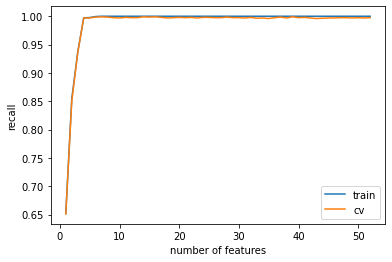

In [27]:
plt.plot(n_feats, train_scores, label="train")
plt.plot(n_feats, cv_scores, label="cv")
plt.legend()
plt.xlabel("number of features")
plt.ylabel("recall");